In [1]:
import os
os.sys.path.append(os.path.dirname(os.path.abspath('.')))

## 数据准备

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from preprocessing.StandardScaler import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, Y = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)
X = StandardScaler().fit_transform(X)

import matplotlib.pyplot as plt
plt.clf()
plt.scatter(X[:,0],X[:,1])
plt.show()

<Figure size 640x480 with 1 Axes>

## 模型基础
为了便于计算，该算法的代码依赖于一个计算样本点之间欧氏距离的函数，详见```..\metrics\pairwise\euclidean_distances.ipynb```。为了方便起见，notebook的示例代码以sklearn中的同名函数为例子。

首先计算出训练数据中两两样本对的欧氏距离，并根据该距离计算所有样本点的密度：

In [3]:
import numpy as np
from metrics.pairwise.euclidean_distances import euclidean_distances

eps = 0.3    # 邻域距离
MinPts = 10    # 形成簇所需的最小样本数

dist_mat = euclidean_distances(X)    # 两两样本点之间的欧氏距离

dens_arr = list()    # 密度数组
for row in dist_mat:
    dens = np.sum(row <= eps)    # 计算密度
    dens_arr.append(dens)
dens_arr = np.array(dens_arr)

由算法定义不难得到一个性质，密度相连的所有**核心**对象肯定属于同一类，所以在遍历样本点时，如果某一核心对象邻域中的另一核心对象已被分类，那么该邻域内的核心对象也属于该类。在实现时可以使用一个队列来存储密度相连的核心对象，每次取出一个核心对象分析：邻域中的核心对象加入队列，邻域中的边界点进行归类，实质上就是一个BFS搜索。

In [4]:
visited_arr = [False for _ in range(len(X))]    # 访问标记数组
labels = [-1 for _ in range(len(X))]    # 所属类别
k = -1    # 第几个类别，初始默认所有样本点均为噪声点

# 遍历样本点
for idx in range(len(X)):
    if visited_arr[idx]:    # 已被访问则跳过
        continue

    visited_arr[idx] = True

    if dens_arr[idx] == 1 or dens_arr[idx] < MinPts:    # 噪声样本或边界样本
        continue

    else:    # 核心对象
        # 访问队列，会在循环中对其进行修改
        cores_q = [i for i in range(
            len(X)) if dist_mat[i, idx] <= eps and dens_arr[i] >= MinPts]
        k += 1    # 新建类别
        labels[idx] = k     # 为当前核心对象赋予类别

        while cores_q:    # BFS式访问密度相连的核心对象
            cur_core = cores_q.pop(0)

            # 对未被访问的核心对象操作，已被访问的核心直接跳过
            if not visited_arr[cur_core]:
                visited_arr[cur_core] = True
                labels[cur_core] = k

                neighbors = [i for i in range(
                    len(X)) if dist_mat[i, cur_core] <= eps]    # 邻域内的所有样本点
                neighbor_cores = [
                    i for i in neighbors if i not in cores_q and dens_arr[i] >= MinPts]    # 邻域内的所有核心对象
                neighbor_boards = [
                    i for i in neighbors if dens_arr[i] < MinPts]    # 邻域内的所有边界样本

                # 核心点加入队列等待访问
                cores_q.extend(neighbor_cores)

                # 边界点进行归类
                for node_idx in neighbor_boards:
                    if labels[node_idx] == -1:
                        labels[node_idx] = k

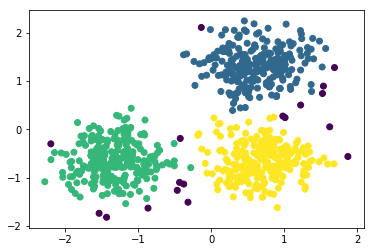

In [5]:
plt.clf()
plt.scatter(X[:,0],X[:,1],c=labels)
plt.show()

## 对比

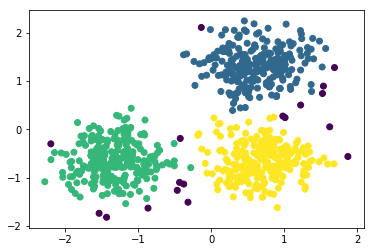

In [6]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=0.3, min_samples=10)
dbscan.fit(X)
sk_labels=dbscan.labels_

plt.clf()
plt.scatter(X[:,0],X[:,1],c=sk_labels)
plt.show()

## 优化
类似于KNN算法，该算法可使用K-D树进行优化。有了能快速查找邻居的KD树，那么就可以免去计算pair-wise的距离矩阵了。```scipy```中的KD树使用示例如下所示：

In [11]:
from scipy.spatial import KDTree
kd_tree=KDTree(X)

kd_tree.query_ball_point(X[0],0.3)    # 找出距X[0]不超过0.3的所有样本的索引

[283,
 736,
 30,
 69,
 377,
 745,
 103,
 233,
 207,
 291,
 339,
 617,
 716,
 28,
 38,
 73,
 230,
 295,
 601,
 628,
 0,
 33,
 226,
 255,
 425,
 572,
 585,
 724,
 91,
 290,
 511,
 513,
 627,
 665,
 719,
 408,
 527,
 530,
 188,
 210,
 269,
 300,
 333,
 348,
 587,
 692,
 249,
 310,
 578,
 118,
 309,
 364,
 478,
 484,
 714]